In [2]:
# load up relavent libraries
library(ggplot2)
library(dplyr)
library(devtools)
library(ggtree)
library(ape)
library(scales)
library(tidyr)
library(forcats)
library(survminer)
library(RColorBrewer)
library(cowplot)
library(forestplot)
library(survminer)
library(survival)
library(xlsx)
library("bayestestR")

Warning message:
“package ‘ggplot2’ was built under R version 3.6.2”
Warning message:
“package ‘dplyr’ was built under R version 3.6.2”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘devtools’ was built under R version 3.6.2”
Loading required package: usethis

Warning message:
“package ‘usethis’ was built under R version 3.6.2”
ggtree v3.1.4  For help: https://yulab-smu.top/treedata-book/

If you use ggtree in published research, please cite the most appropriate paper(s):

1. Guangchuang Yu. Using ggtree to visualize data on tree-like structures. Current Protocols in Bioinformatics, 2020, 69:e96. doi:10.1002/cpbi.96
2. Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods for mapping and visualizing associated data on phylogeny using ggtree. Molecular Biology and Evolution 2018, 35(12):3041-3

In [3]:
# general settings
theme_set(theme_classic() + theme(text = element_text(size=16, family = "sans"),
         plot.title = element_text(hjust = 0.5,size=16,face="bold")))
lineage_colors <- c("#e69f00","firebrick","#6794a7", "#014d64", "#01a2d9" ,
                    "#7ad2f6" ,"#00887d", "#76c0c1", "lightblue", "gray"  )
pop_colors <- c("#938dd2","#E69F00" ,"#56B4E9","#999999","#009E73","#D55E00")
pop_labels <- c("African","East Asian","European","Admixed American", "South Asian","Lima")

g2g_L2_colors <- c('#E64B35FF','#4DBBD5FF')
options(StringsAsFactors=FALSE)
options(repr.plot.width = 10, repr.plot.height = 7)

# Histogram of genomic inflation factor (lambda_gc) of all 1,267 genome-wide association analysis

In [5]:
lambdagc <- read.table("../data/SNP_lambdagc.txt",h=F)
lambdaHist <- ggplot(lambdagc,aes(V2))+geom_histogram() + 
    xlab(expression(lambda[gc]))+ylab("Count")
dim(lambdagc)
median(lambdagc$V2)
mean(lambdagc$V2)

[1] 1267    2

[1] 1.008185

[1] 1.009813

Warning message:
“Use of `lambdagc$V2` is discouraged. Use `V2` instead.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Use of `lambdagc$V2` is discouraged. Use `V2` instead.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



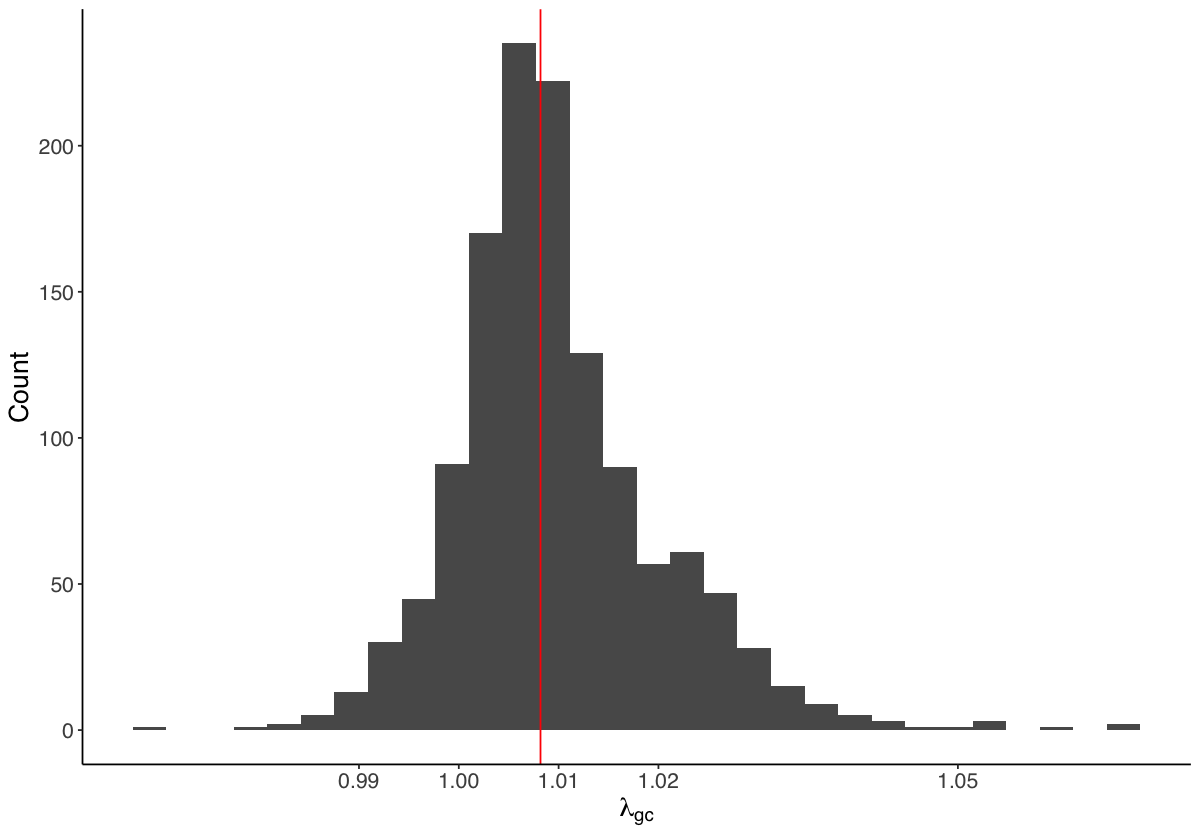

In [8]:
lambdaHist + geom_vline(aes(xintercept = median(lambdagc$V2)),col='red') +
scale_x_continuous(breaks = c(0.99,1,1.01,1.02,1.05))

ggsave("../figures/SF1_lambdagc.pdf",width=9,height=6)

# permutation p-value threshold

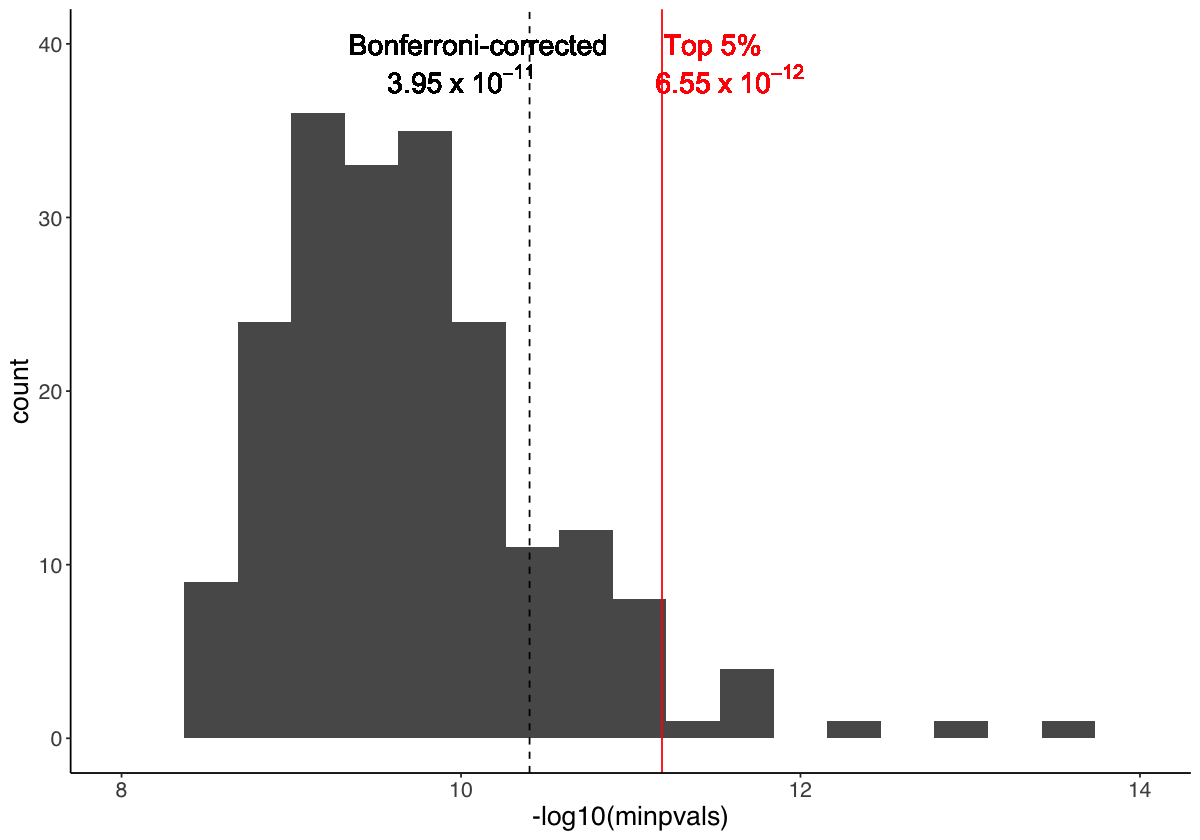

In [5]:
minpvals <- scan("../data/perm-pvals.txt",as.numeric())
bonf <- 5e-8/1267

threshold <- minpvals[order(minpvals)][length(minpvals)*0.05]

a <- 40

perm.plt <- ggplot(data.frame(minpvals),aes(-log10(minpvals))) + geom_histogram(bins=20) +
    geom_vline(aes(xintercept = -log10(threshold)), colour="red") +
    geom_text(x=-log10(threshold)+.3,y=a,label="Top 5%",size=6,col="red") +
    geom_text(x=-log10(threshold)+.4,y=a-2,label=expression(6.55~x~10^{-12}),size=6,col="red")+
    geom_vline(aes(xintercept = -log10(bonf)), colour="black",linetype="dashed") +
    geom_text(x=-log10(bonf)-.3,y=a,label="Bonferroni-corrected",size=6) +
    geom_text(x=-log10(bonf)-.4,y=a-2,label=expression(3.95~x~10^{-11}),size=6)+
    xlim(8,14) + ylim(0,a)

perm.plt
ggsave("../figures/SF2_permutation_pvals.pdf",width=9,height=6)

# P-P plot eQTL versus g2g pvals

In [41]:
pos <- read.table("~/Downloads/hglft_genome_1c558_76d720.bed",h=F,stringsAsFactors = F)
dim(pos)
dim(gwas)
gwas$id <- paste("6:",pos$V3,sep="")
head(gwas)

write.table(gwas %>% select("rs","af","beta","se","p_lrt","id"),
            "../data/MHCimp.97.assoc.txt",quote=F,row.names=F,col.names=T)

[1] 47505     3

[1] 47505    10

,rs,af,beta,se,p_lrt,id,eQTL,eQTLpval,eQTLbeta,eQTLvariant
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
1,rs1529749:6:28000361,0.078,0.004063635,0.02931610,0.95671590,6:28032583,NA,NA,NA,NA
2,rs17765491:6:28000610,0.078,0.004461182,0.02930195,0.94515570,6:28032832,NA,NA,NA,NA
3,rs17708949:6:28001003,0.063,-0.003448329,0.03118691,0.89593130,6:28033225,NA,NA,NA,NA
4,rs149941:6:28001033,0.292,0.028889080,0.01626819,0.06368949,6:28033255,NA,NA,NA,NA
5,rs149942:6:28001610,0.292,0.028889080,0.01626819,0.06368949,6:28033832,NA,NA,NA,NA
6,rs9393873:6:28002045,0.079,0.003519968,0.02913548,0.97063660,6:28034267,NA,NA,NA,NA


In [62]:
# read in gwas and eQTL summary stats
gwas <- read.table("../data/MHCimp.97.assoc.txt.gz",h=T)
eQTL <- read.table("../data/GTEx_v8_lung_eQTL_summary_stats.txt.gz",h=T)

gwas$eQTL <- eQTL[match(gwas$id,eQTL$id),]$pvalue
gwas$eQTLpval <- eQTL[match(gwas$id,eQTL$id),]$pvalue # check position and allele consistency
gwas$eQTLbeta <- eQTL[match(gwas$id,eQTL$id),]$beta # check position and allele consistency

gwas$eQTLvariant <- eQTL[match(gwas$id,eQTL$id),]$variant

df <- na.omit(gwas) # only plotting overlap variants between two datasets

dim(df)
df[df$p_lrt==min(df$p_lrt),]


[1] 14967    10

,rs,af,beta,se,p_lrt,id,eQTL,eQTLpval,eQTLbeta,eQTLvariant
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
12182,rs3132583:6:30688575,0.011,0.3262018,0.04120181,9.236314e-15,6:30720798,2.2168e-16,2.2168e-16,0.28213,chr6_30720798_G_C
12244,rs3130658:6:30701092,0.011,0.3262018,0.04120181,9.236314e-15,6:30733315,2.2168e-16,2.2168e-16,0.28213,chr6_30733315_C_T
12270,rs3130660:6:30706361,0.011,0.3262018,0.04120181,9.236314e-15,6:30738584,2.2168e-16,2.2168e-16,0.28213,chr6_30738584_T_A


In [63]:
y <- -log10(df$p_lrt)
x <- -log10(df$eQTLpval)

regDf <- data.frame(x=x,y=y,wght1=abs(df$beta*df$eQTLbeta))

fit <- summary(lm(y~x,data=regDf,weights=wght1))
#correlation R
sqrt(fit$r.squared)
#fit$fstatistic

#correlation p-value (in log10)
pf(fit$fstatistic[1],fit$fstatistic[2],fit$fstatistic[3],lower.tail=FALSE,log.p=TRUE)/log(10)


[1] 0.8925072

value 
-5176.906

[1] 0

Warning message:
“Ignoring unknown parameters: shape, stroke”
Warning message:
“Removed 3 rows containing missing values (geom_smooth).”
Warning message:
“Removed 3 rows containing missing values (geom_smooth).”


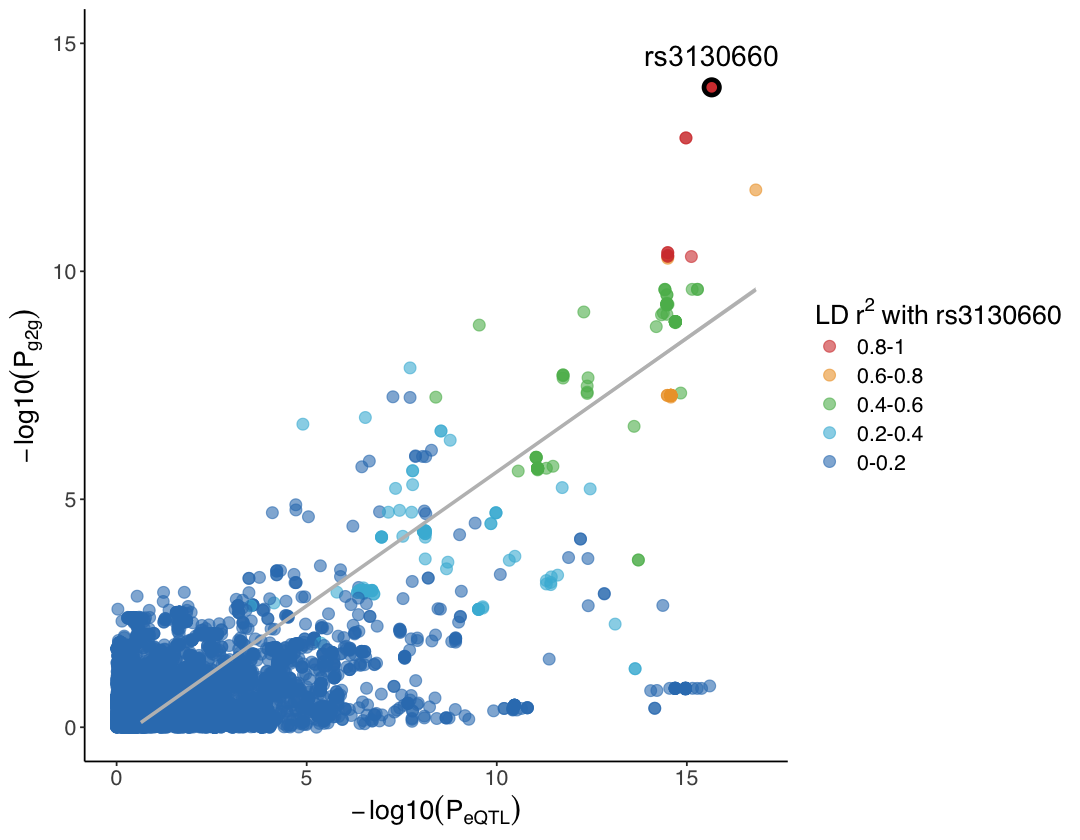

In [75]:
r2 <- read.table("../data/rs3130660_TBg2g_r2.txt.gz",h=T)
df$pos <- sapply(strsplit(as.character(df$rs), ":"), "[[", 3)

df$R2 <- 0
df$R2 <- r2[match(df$pos,r2$BP_B),]$R2
df$R2 <- ifelse(is.na(df$R2),0,df$R2)
sum(is.na(df$R2))

bins <- c(-Inf,0.2,0.4,0.6,0.8,1)

pp <- ggplot2::ggplot(data=df) +
    ggplot2::xlab((bquote(-log10(P[eQTL])))) +
    ggplot2::ylab((bquote(-log10(P[g2g])))) +
    ggplot2::theme(legend.position = "right") +
    theme(legend.spacing.y = unit(0.1, "cm")) + 
    theme(legend.key = element_rect(fill = NA, colour = NA, size = 0.25))+ylim(0,15)


pp <-  pp    +  ggplot2::geom_point(data=df,
                          aes(y=-log10(p_lrt), x=-log10(eQTLpval),color=cut(R2,bins)), size = 3)  +
      ggplot2::geom_smooth(data=df,
                           aes(y=-log10(p_lrt), x=-log10(eQTLpval),weight=abs(beta*eQTLbeta)), color = "grey", method = "lm", formula = (y ~ x)) 


signfSNP <- 'rs3130660:6:30706361'

options(repr.plot.width = 9, repr.plot.height = 7)

r2col <- (c('#D43F3A99','#EEA23699','#5CB85C99','#46B8DA99','#357EBD99'))

pp  <- pp +  scale_color_manual(bquote("LD" ~ r^2 ~ "with" ~{.("rs3130660")}), 
                          values = rev(c("(-Inf,0.2]" = r2col[5],
                                    "(0.2,0.4]"= r2col[4],
                                    "(0.4,0.6]" = r2col[3],
                                    "(0.6,0.8]" = r2col[2],
                                    "(0.8,1]" = r2col[1])),
                        label=rev(c("0-0.2","0.2-0.4","0.4-0.6","0.6-0.8","0.8-1")))

pp <- pp + geom_point(df %>% filter(rs==signfSNP),
               mapping= aes(y=-log10(p_lrt), x=-log10(eQTLpval)),
               colour="black",shape=1,size=3,stroke=2)

pp <- pp + geom_text(df %>% filter(rs==signfSNP),
               mapping= aes(y=-log10(p_lrt)*1.05, x=-log10(eQTLpval)),
               colour="black",shape=1,size=6,stroke=2,
              label="rs3130660") 
pp


ggsave("../figures/SF3_coloc_PP.pdf",width=9,height=6)

# coloc between 49 *cis*-genes in 108 bulk RNA-seq dataset obtain from eQTL catalog v4

In [78]:
coloc <- read.table("../data/coloc_results.txt",h=T)
head(coloc)

,RNAseq_dataset,Gene,coloc_posterior
,<fct>,<fct>,<dbl>
1,Alasoo_2018_macrophage_naive,HLA-A,0.008801835
2,Alasoo_2018_macrophage_naive,ZNRD1,0.033096163
3,Alasoo_2018_macrophage_naive,PPP1R11,0.008707314
4,Alasoo_2018_macrophage_naive,RNF39,NA
5,Alasoo_2018_macrophage_naive,TRIM31,NA
6,Alasoo_2018_macrophage_naive,TRIM40,NA


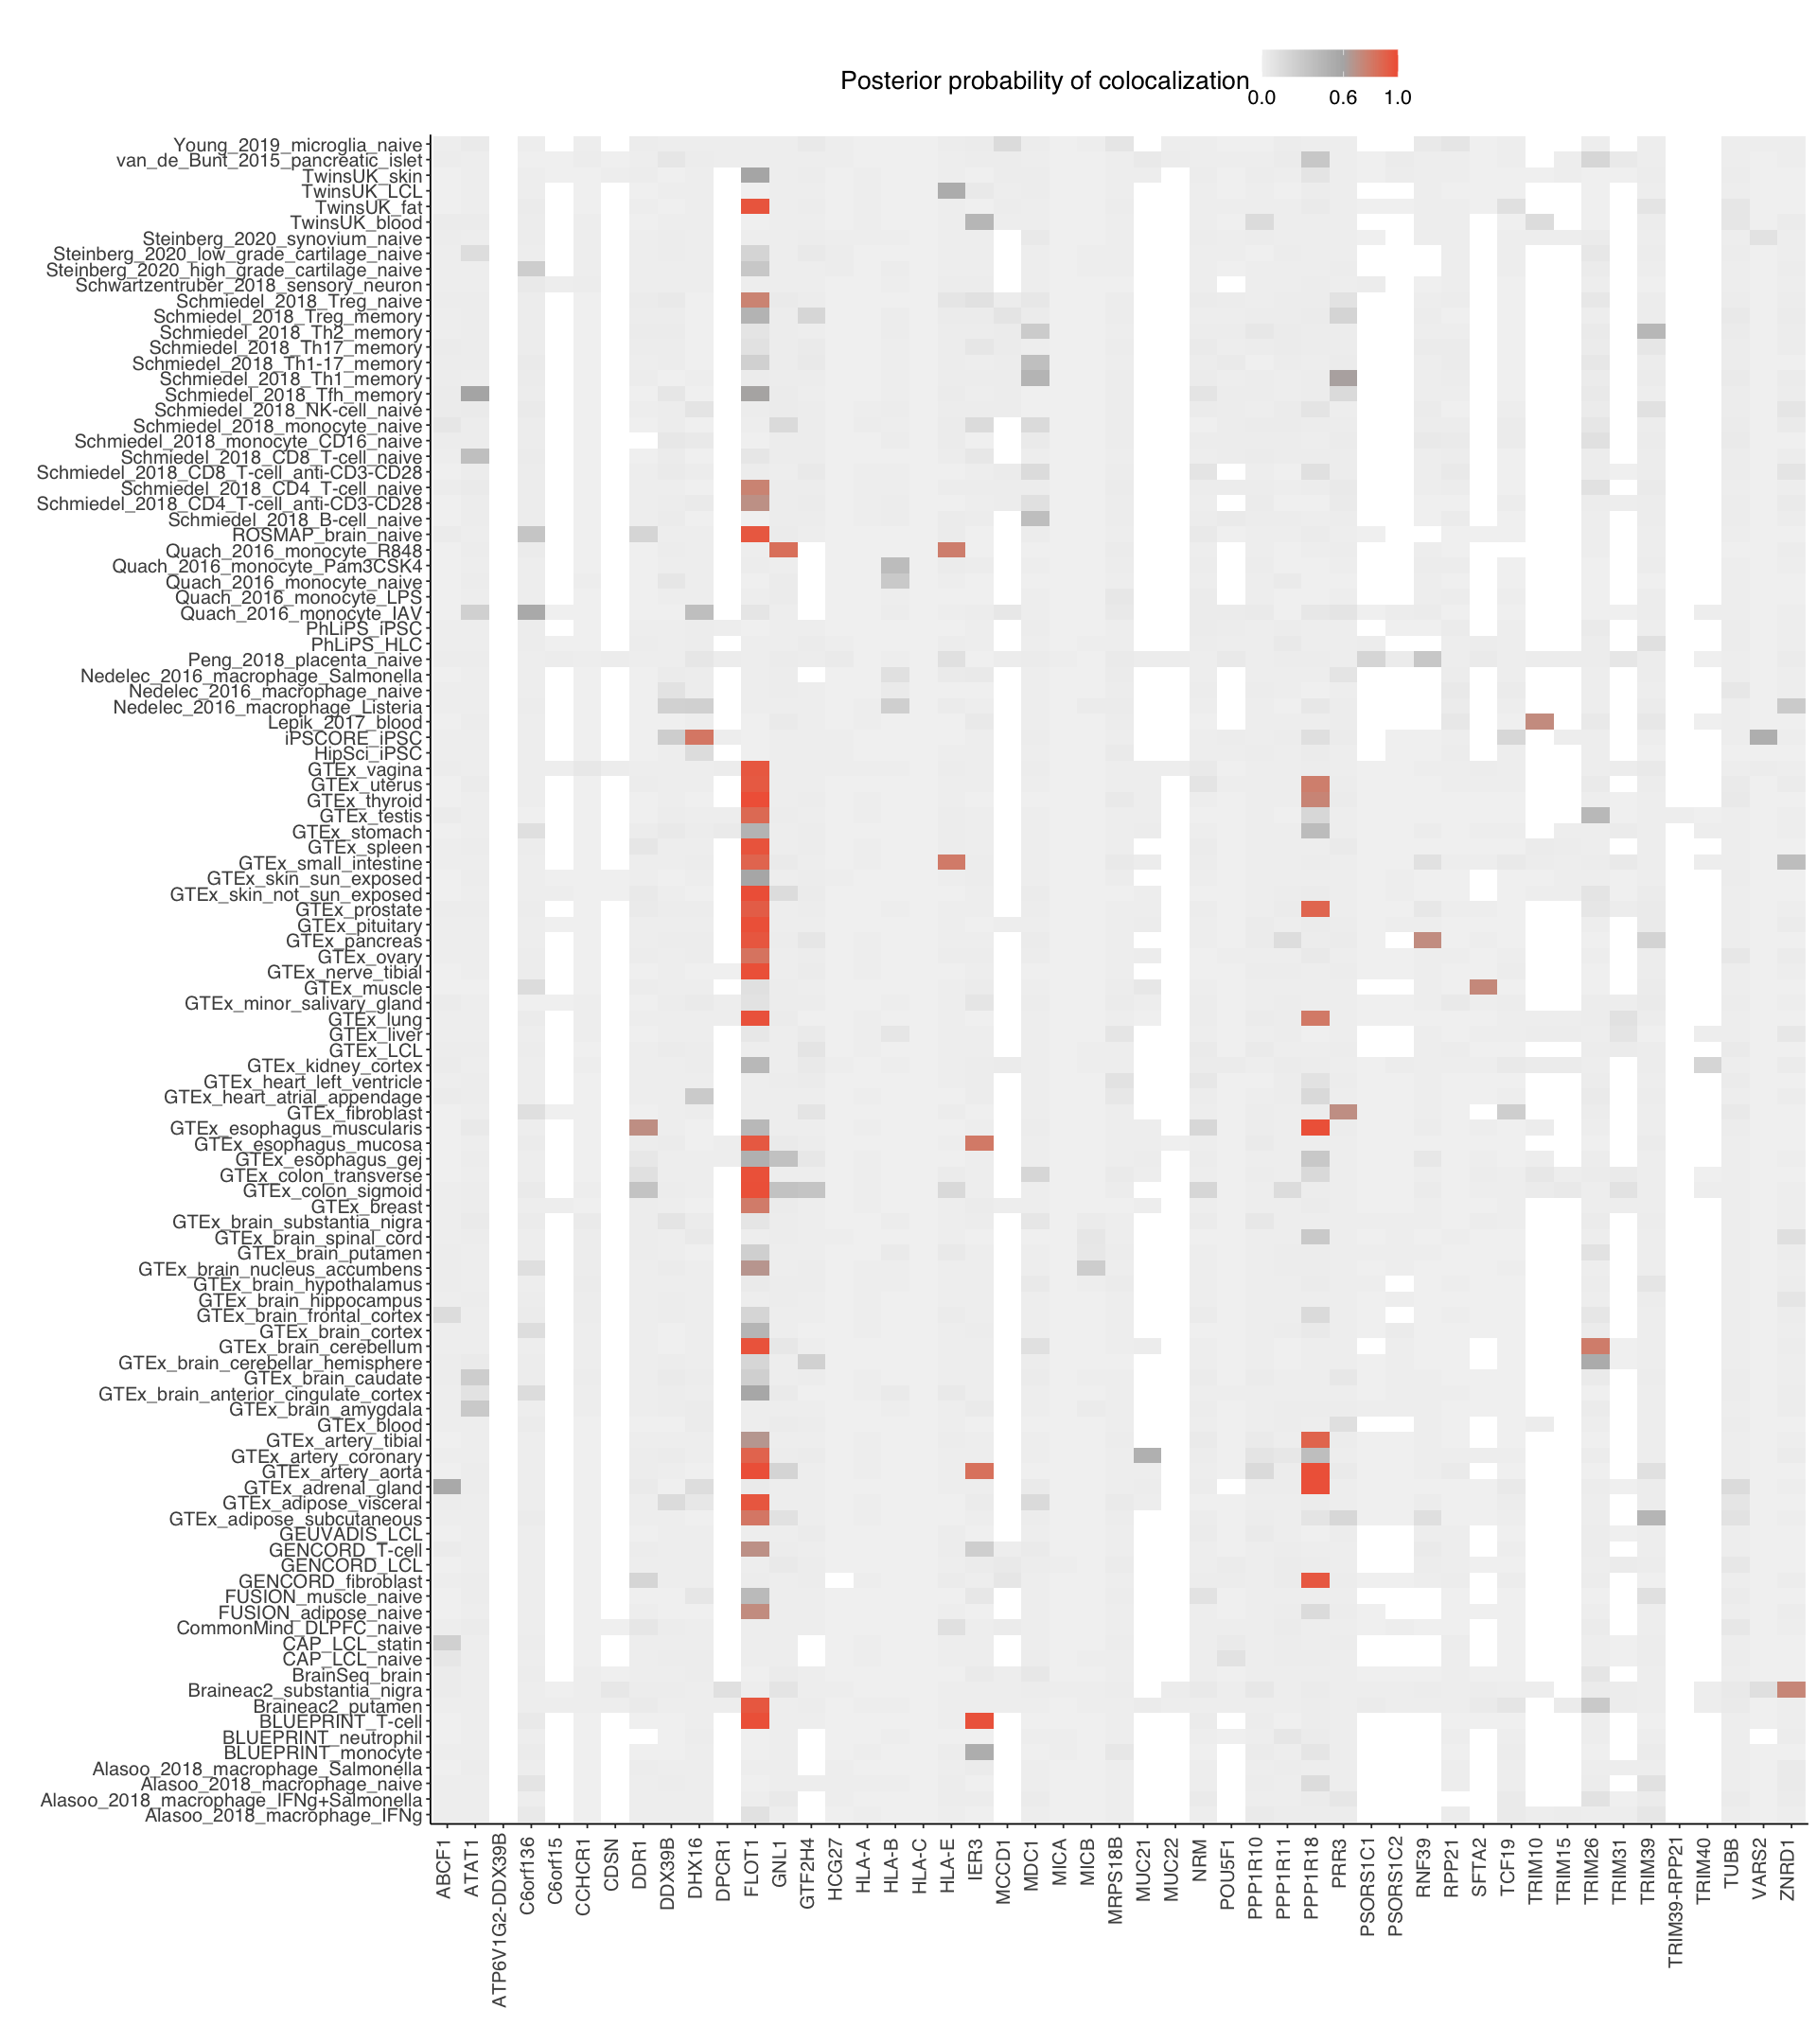

In [85]:
options(repr.plot.width = 16, repr.plot.height = 18)

Pcoloc <- ggplot(coloc, aes(x = Gene, y = RNAseq_dataset)) + 
  geom_raster(aes(fill=coloc_posterior)) + 

 scale_fill_gradient2(low = "grey95", mid = "grey70", high = "red",
                      midpoint=0.6,na.value="white",breaks=c(0,0.6,1), limits=c(0,1),
                      name="Posterior probability of colocalization")+
  labs(title="") + ylab("") + xlab("")+
   theme(legend.position="top",axis.text.x=element_text(size=12, angle=90, ,hjust=0.95,vjust=0.2),
                     axis.text.y=element_text(size=12),
                     plot.title=element_text(size=16))

Pcoloc
ggsave("../figures/SF5_coloc_all.pdf",width=18,height=20)

In [ ]:
#